In [1]:
import json
import glob
import os

import imgaug.augmentables as ia
import albumentations as A

from shapely import geometry
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
import numpy as np

import torchvision as tv

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch

import pytorch_lightning as pl

from effdet.modeling_efficientdet import EfficientDetDoesEAST
from effdet.east_losses import BalancedBCE

ModuleNotFoundError: No module named 'effdet'

In [2]:
image_folder = './train_images/'
image_files = glob.glob('./train_images/*.jpg')
with open('./train_labels.json', 'rb') as f:
    image_labels = json.load(f)

In [3]:
len(image_files), len(image_labels)

(5603, 5603)

In [4]:
def get_image_and_mask_from_name(gt_name, image_type=np.uint8, mask_type=np.uint8):
    annotations = image_labels[gt_name]
    image = Image.open(os.path.join(image_folder, f'{gt_name}.jpg'))
    mask = Image.new('L', size=image.size, color=0)
    draw = ImageDraw.Draw(mask)
    for annot in annotations:
        draw.polygon(tuple(tuple(xy) for xy in annot['points']), fill=255)
    np_image = np.array(image, dtype=image_type)
    np_mask = (1 * (np.array(mask) != 0)).astype(mask_type)
    return np_image, np_mask

In [5]:
def view_image_and_mask(image, mask):
    ia_mask = ia.SegmentationMapsOnImage(mask, mask.shape)
    return Image.fromarray(ia_mask.draw_on_image(image.astype(np.uint8), alpha=0.5)[0])

In [6]:
np_image, np_mask = get_image_and_mask_from_name('gt_600')

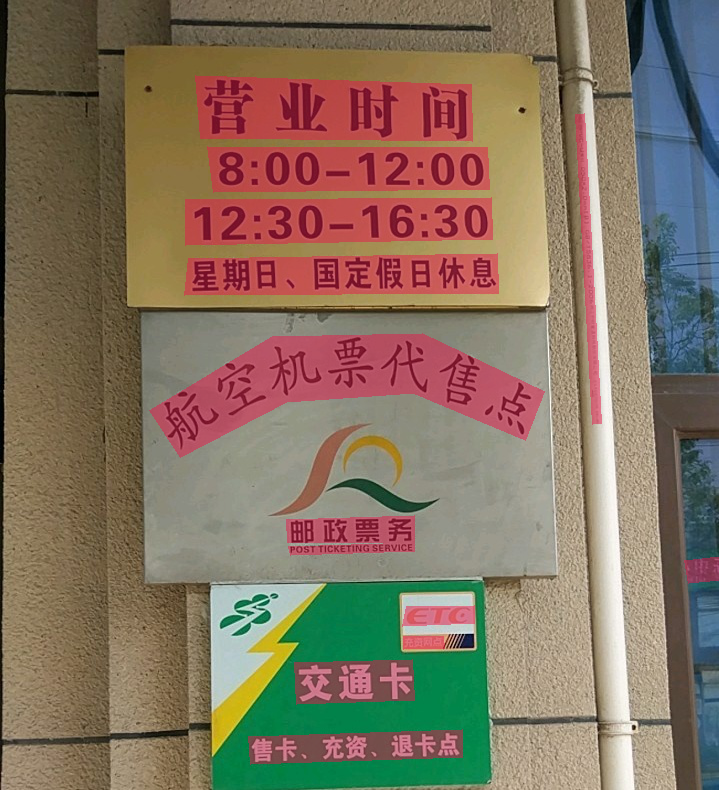

In [7]:
view_image_and_mask(np_image, np_mask)

# Dataset

In [8]:
class ArTDataset(Dataset):
    
    
    resize_tfms = A.Resize(768, 768)
    resize_mask_tfms = A.Resize(768//4, 768//4)
    
    train_tfms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.IAAAffine(scale=(0.9, 1.1), translate_percent=(-0.1, 0.1), rotate=(-10, 10), p=0.3),
    ])
    
    lambda_tfms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(lambda x: 2 * x -1) # for EffNet advprop
    ]) 
        
    def __init__(self, image_names:str, image_labels:dict, is_train=False):
        self.image_names = image_names
        self.image_labels = image_labels
        self.is_train = is_train
        
    def __len__(self,):
        return len(self.image_names)
        
    def __getitem__(self, idx):
        gt_name = self.image_names[idx]
        image_org, mask = get_image_and_mask_from_name(gt_name)
        
        # RESIZE
        transformed = self.resize_tfms(image=image_org, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        
        if self.is_train:
            transformed = self.train_tfms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # NORMALIZE
        image = self.lambda_tfms(image)
        
        
        # RESIZE MASK
        transformed = self.resize_mask_tfms(image=image_org, mask=mask)
        mask = transformed['mask']
        
        return image, mask

In [9]:
ds_debug = ArTDataset(['gt_10', 'gt_15'], image_labels, is_train=True)

In [10]:
img, mask = ds_debug[1]
# img = (img + 1.) / 2.
# view_image_and_mask(img.permute(1, 2, 0).numpy()*255, mask)

In [11]:
img.shape, mask.shape

(torch.Size([3, 768, 768]), (192, 192))

In [12]:
class ArTDataModule(pl.LightningDataModule):
    
    def __init__(self, image_labels, val_pct=0.1, train_bs=2, valid_bs=4):
        super().__init__()
        self.image_labels = image_labels
        self.image_names = sorted(list(image_labels.keys()))
        self.train_bs = train_bs
        self.valid_bs = valid_bs
        self.val_pct = val_pct
        
    def setup(self, stage):
        if stage == 'fit':
            train_size = round(len(self.image_names) * self.val_pct)
            self.train_dataset = ArTDataset(self.image_names[:train_size], image_labels)
            self.valid_dataset = ArTDataset(self.image_names[train_size:], image_labels)
        if stage == 'test':
            self.test_dataset = self.valid_dataset
            
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_bs, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.valid_bs)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.valid_bs)

In [13]:
def visualize_batch(img, mask):
    grid_image = tv.utils.make_grid(img, nrow=8)
    iam = ia.SegmentationMapsOnImage(mask.permute(1,2,0).numpy(), shape=mask.shape[1:])
    iam = iam.resize(768)
    mask = torch.tensor(iam.arr).permute(2, 0, 1)

    grid_mask = tv.utils.make_grid(mask.unsqueeze(1), nrow=8)

    plt.figure(figsize=(20,20))
    grid_image = (grid_image + 1)/2
    plt.imshow(grid_image.permute(1,2,0))
    plt.imshow(grid_mask.permute(1,2,0)*255, alpha=.5)

In [14]:
dm_kwargs = {
    'val_pct': 0.1,
    'train_bs': 2,
    'valid_bs': 4
}

In [15]:
data_module = ArTDataModule(image_labels, **dm_kwargs)

In [16]:
data_module.setup('fit')

In [17]:
img, mask = next(iter(data_module.train_dataloader()))

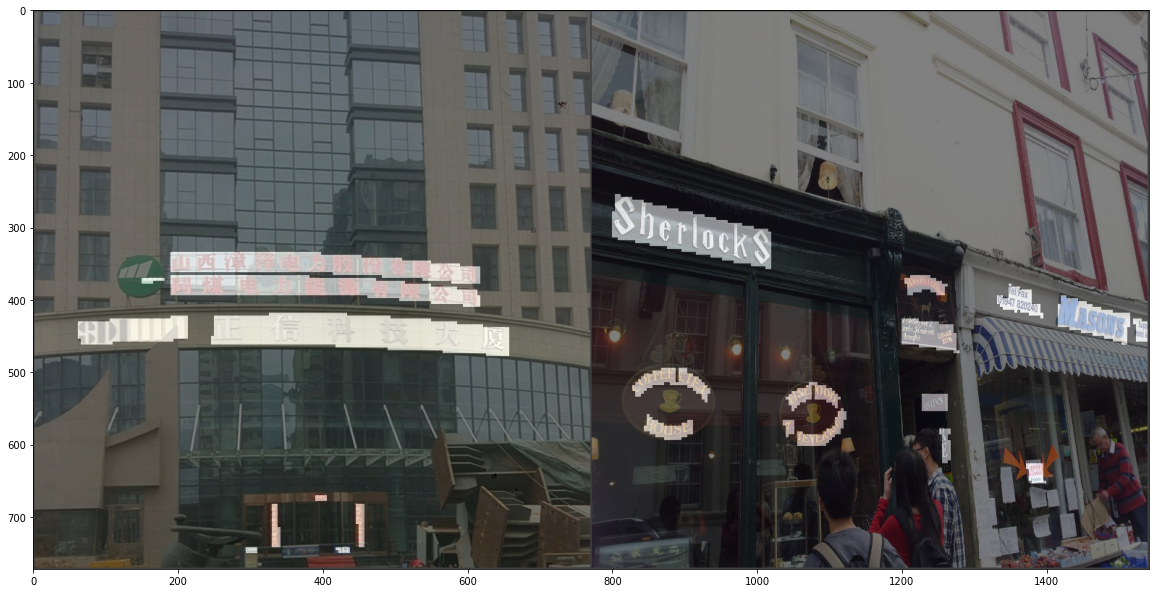

In [18]:
visualize_batch(img, mask)

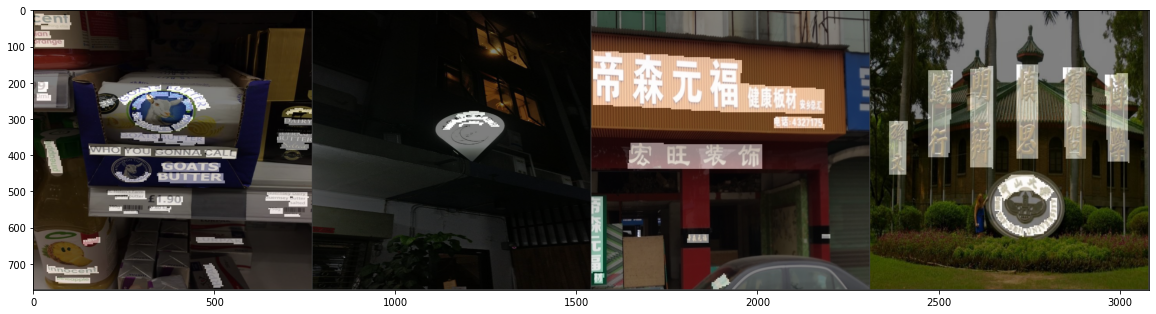

In [19]:
img, mask = next(iter(data_module.val_dataloader()))
visualize_batch(img, mask)

# Model

In [40]:
class DiceLoss(nn.Module):
    
    def forward(self, y_true, scores, eps=1e-8):
        # compute the actual dice score
        dims = (1, 2)
        intersection = torch.sum(scores * y_true, dims)
        cardinality = torch.sum(scores + y_true, dims)

        dice_score = 2. * intersection / (cardinality + eps)
        return torch.mean(-dice_score + 1.)

In [41]:
class EffDetSegmentationPart(EfficientDetDoesEAST):
    
    def forward(self, x):
        _, _, height, width = x.shape
        feats = self.backbone(x)

        scores = self.scores(feats)
        scores = torch.sigmoid(scores)

        score_map = scores[:, 0] # take only the segmentation scores
        return score_map

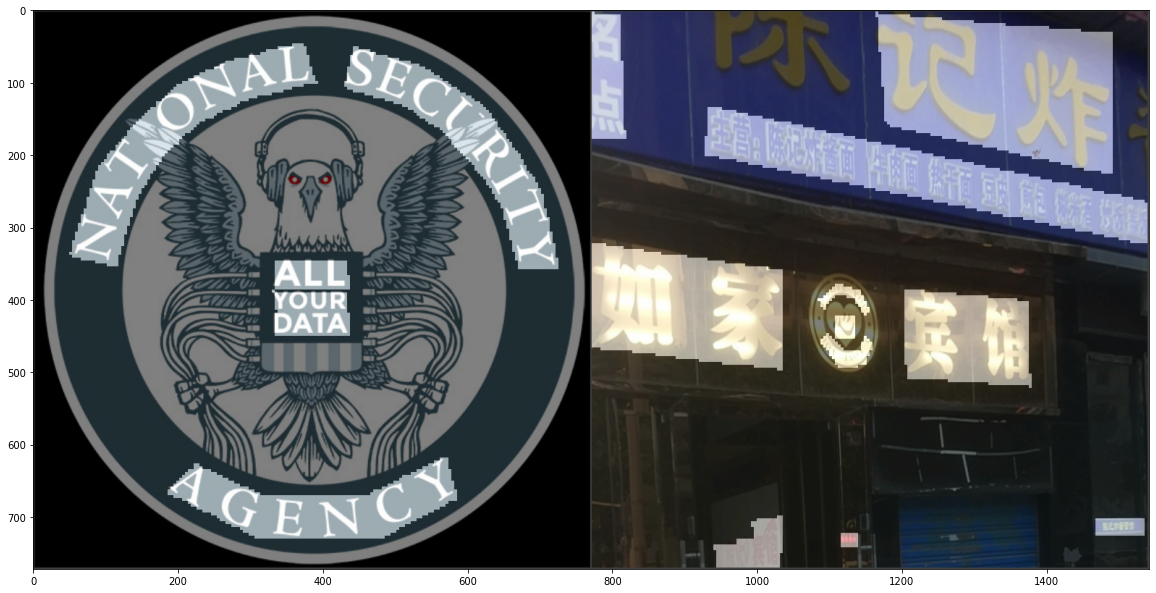

In [42]:
img, mask = next(iter(data_module.train_dataloader()))
visualize_batch(img, mask)

In [58]:
model = EffDetSegmentationPart(advprop=True, compound_coef=4)

Loaded pretrained weights for efficientnet-b4


In [59]:
model.eval()
with torch.no_grad():
    scores = model(img)

In [60]:
scores.shape, mask.shape

(torch.Size([2, 192, 192]), torch.Size([2, 192, 192]))

In [61]:
loss_fn = DiceLoss()

In [62]:
mask.shape, scores.shape

(torch.Size([2, 192, 192]), torch.Size([2, 192, 192]))

In [63]:
loss = loss_fn(mask, scores)

In [64]:
loss

tensor(0.6919)

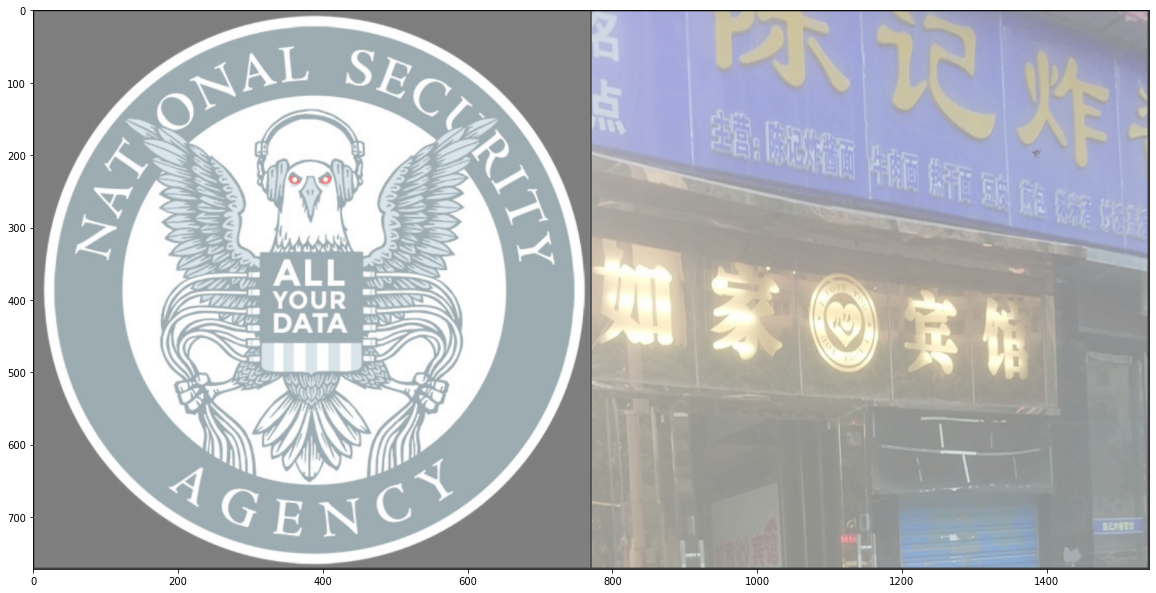

In [65]:
pred = (1*(scores > 0.5)).type(torch.uint8)
visualize_batch(img, pred)

In [66]:
model.cuda()

EffDetSegmentationPart(
  (backbone): EfficientDetForSemanticSegmentation(
    (bifpn): Sequential(
      (0): BiFPN(
        (conv6_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), groups=128, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        (conv5_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), groups=128, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)


In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
model.backbone.backbone_net.requires_grad_(False)

EfficientNet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [69]:
for _ in range(100):
    model.train()
    model.backbone.freeze_bn() # freeze BN
    
    model.zero_grad()
    
    scores = model(img.cuda())
    loss = loss_fn(mask.cuda(), scores)
    
    if loss.isnan().item():
        model.zero_grad()
        break
    
    loss.backward()
    optimizer.step()
    
    print(loss)

tensor(0.6918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6916, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6913, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6910, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6908, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6905, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6902, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6895, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6882, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6876, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6852, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6839, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6823, device='cuda:0',

In [70]:
loss

tensor(0.0878, device='cuda:0', grad_fn=<MeanBackward0>)

In [71]:
scores

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          2.2205e-27, 1.2850e-12],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 5.1200e-24],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 1.3823e-33],
         ...,
         [2.5498e-34, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.000

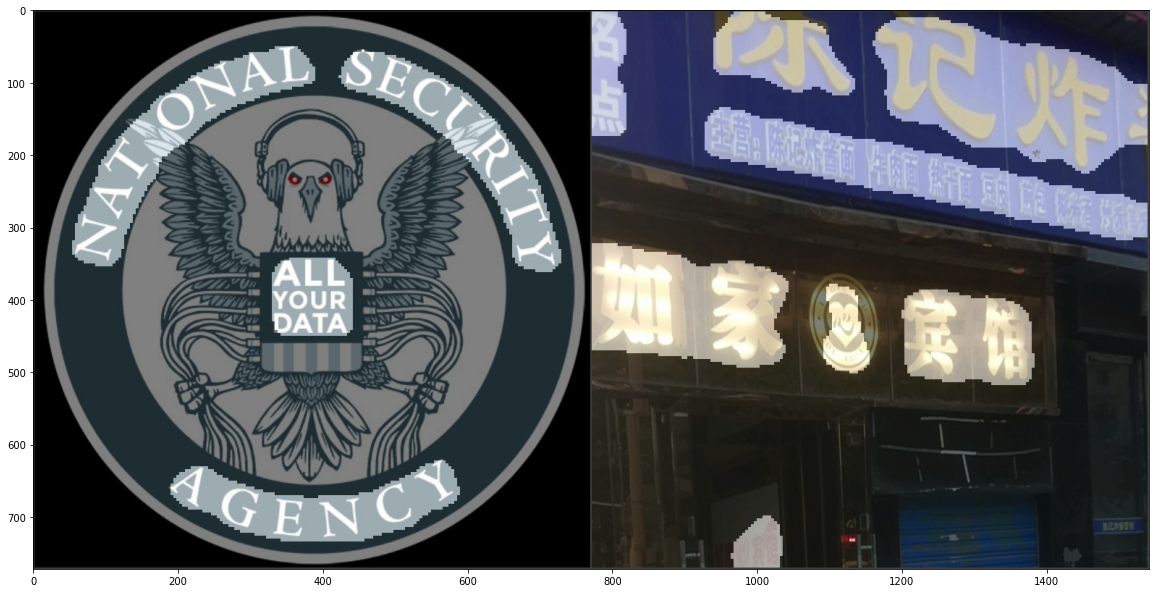

In [72]:
model.eval().cpu()
with torch.no_grad():
    scores = model(img)
pred = (1*(scores > 0.5)).type(torch.uint8)
visualize_batch(img, pred)